### Задание 1
* Провести мониторинг позиций из листа "Данные для задачи 1", подготовить индекс цен по конкурентам (форма свободная), дать предложение об изменении наценок с учётом того, что стратегия встать в минимальную цену на рынке.
* Взять конкурентов Летуаль, РивГош, Озон, Вайлдберрис. Ссылки на сайт ЗЯ можно найти через добавление в поиск кода товара.

* На основе статистики скидок и количества продаж по данным позициям дать предложение по размеру скидки, чтобы увеличить продажи в 2 раза.															


In [136]:
import requests as requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [424]:
#загрузим таблицу с продуктами
df_prod = pd.read_excel('sourse.xlsx', sheet_name='Данные для задачи 1', usecols = "A:D").dropna()
df_prod.rename(columns={'Бренд':'brand','Код товара':'code','Наименование товара':'product','Цена закупки товара':'price_buy'},inplace=True)
df_prod = df_prod.astype({'code':'int'})
df_prod.head(3)

brand         code  \
0  Vivienne Sabo   3226300004   
1       Shiseido  15111300017   
2       Shiseido  15111300006   

                                             product     price_buy  
0  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...    180.528662  
1  SHISEIDO Future Solution LX Сыворотка д/здоров...  14919.363057  
2  SHISEIDO Крем для тела восстанавливающий FUTUR...   6197.273885

In [425]:
#загрузим таблицу с продажами
df_selling = pd.read_excel('sourse.xlsx', sheet_name='Данные для задачи 1', usecols = "F:J").dropna()
df_selling.rename(columns={'Дата':'date','Код товара.1':'code','Количество продано':'q_sell','Розничная цена':'price_retail','Цена с учётом скидки':'price_discount'},inplace=True)
df_selling = df_selling.astype({'price_retail':'float'})
df_selling.head(3)

date        code  q_sell  price_retail  price_discount
0 2021-06-01  3226300004       9         271.0           271.0
1 2021-06-02  3226300004      15         271.0           271.0
2 2021-06-03  3226300004      12         271.0           216.8

In [426]:
#общий датафрейм после объединения таблиц будет выглядеть следующим образом
df = df_prod.merge(df_selling, on='code', how='inner')
df.head(3)

brand        code  \
0  Vivienne Sabo  3226300004   
1  Vivienne Sabo  3226300004   
2  Vivienne Sabo  3226300004   

                                             product   price_buy       date  \
0  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-01   
1  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-02   
2  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-03   

   q_sell  price_retail  price_discount  
0       9         271.0           271.0  
1      15         271.0           271.0  
2      12         271.0           216.8

In [428]:
#посмотрим на период выборки (min & max значения)
df.date.describe(datetime_is_numeric=True)

count                   1220
mean     2021-07-31 12:00:00
min      2021-06-01 00:00:00
25%      2021-07-01 00:00:00
50%      2021-07-31 12:00:00
75%      2021-08-31 00:00:00
max      2021-09-30 00:00:00
Name: date, dtype: object

In [813]:
#выборка составлена за период с 2021-06-01 по 2021-09-30 (4 месяца)
#добавим столбец с месяцем в анализируемый фрейм
df['month'] = df.apply(lambda x: x.date.month_name(),axis=1)
df.head(3)

brand        code  \
0  Vivienne Sabo  3226300004   
1  Vivienne Sabo  3226300004   
2  Vivienne Sabo  3226300004   

                                             product   price_buy       date  \
0  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-01   
1  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-02   
2  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-03   

   q_sell  price_retail  price_discount month  sell_buy  sell_retail  \
0       9         271.0           271.0  June     1.625        2.439   
1      15         271.0           271.0  June     2.708        4.065   
2      12         271.0           216.8  June     2.166        3.252   

   sell_discount  
0          2.439  
1          4.065  
2          2.602

In [430]:
#проанализируем исходную таблицу:
print(f"кол-во брендов: {df.brand.nunique()}\nкол-во тов позиций {df.code.nunique()} \nкол-во поз по брендам:\n {df.groupby(['brand'])['code'].nunique().reset_index()}")

кол-во брендов: 3
кол-во тов позиций 10 
кол-во поз по брендам:
            brand  code
0        Clarins     4
1       Shiseido     4
2  Vivienne Sabo     2


## Часть 1 задания 1 
### Исследуем конкурентов по представленным товарным позициям
Для этого соберем актуальные цены на текущий момент с сайта Золотого Яблока используя get-запросы на сайт по кодам 

#### функции для запроса актуальных цен на исследуемые товарные позиции с сайта Золотого Яблока:

In [435]:
#функции для запроса актуальных цен на исследуемые товарные позиции с сайта Золотого Яблока
def get_response_soup(url):
    try:
        response = requests.get(url=url)
        soup = BeautifulSoup(response.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as err:
        print(err, url)
        
def get_price_val_from_goldapple(soup):
    return soup.find_all('div',class_='price-box price-final_price')[1].find('span',class_='price').text.split()

def get_price(list_val):
    p = str()
    for i in range(len(list_val)-1):
        p = p + list_val[i]
    return float(p) 

def get_actual_price_goldapple(url='https://goldapple.ru/catalogsearch/result?q=',df_prod=df_prod):
    codes, prices = list(), list()
    for i in range(len(df_prod)):
        u = url + str(df_prod.iloc[i].code)
        s = get_response_soup(u)
        codes.append(df_prod.iloc[i].code)
        prices.append(get_price(get_price_val_from_goldapple(s)))
    dd = dict(zip(codes,prices))   
    return pd.DataFrame.from_dict(
        dd, orient='index',columns=['actual_price_goldapple']).reset_index().rename(columns={'index':'code'})

def get_tuple_code_title_prod(df_prod=df_prod):
    list_title_prod = list(df_prod['product'])
    list_code_prod = list(df_prod['code'])
    list_code_title_prod = list(zip(list_code_prod,list_title_prod))
    return list_code_title_prod

In [434]:
# цены Золотого Яблока (собраны с сайта по кодам) и сформированы в датафрейм
df_goldapple = get_actual_price_goldapple()
df_goldapple

code  actual_price_goldapple
0   3226300004                   426.0
1  15111300017                 27885.0
2  15111300006                 11583.0
3  15110900016                  2399.0
4  19760336592                  3289.0
5  14011400047                  2400.0
6  14012900005                  1800.0
7  19000013047                  3900.0
8   3234800007                   417.0
9  19000000363                  3225.0

* Цены конкурентов будем искать вручную на сайтах и вносить с клавиатуры, формируя датафреймы
* такой метод используется для избежания исключения из поиска однотипных товаров, которые предлагают поисковики 
* для поиска используем наименование товара

In [439]:
# функция для сбора актуальных цен конкурентов в датафрейм
#(будем использовать функцию input() для ввода найденных цен вручную с клавиатуры)
def search_price_competitors(competitor='competitor',list_code_title_prod=list_code_title_prod):
    code_list,let_price = list(),list()
    for n in range(len(list_code_title_prod)):
        print(list_code_title_prod[n][0],'----',list_code_title_prod[n][1],':  ' )
        price = round(float(input(list_code_title_prod[n][1])),1)
        if price != 0:
            let_price.append(price)
        else:
            let_price.append(None)
        code_list.append(list_code_title_prod[n][0])
    dd = dict(zip(code_list,let_price))
    col_name = 'actual_price_' + competitor
    return pd.DataFrame.from_dict(
            dd, orient='index',columns=[col_name]).reset_index().rename(columns={'index':'code'})

In [440]:
# сбор данных Летуаль
df_letual = search_price_competitors('letual')
df_letual

3226300004 ---- Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04 :  
Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 040
15111300017 ---- SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл :  
SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл32579
15111300006 ---- SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл :  
SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл0
15110900016 ---- Шисейдо Крем д/упругости бюста ароматический 75мл :  
Шисейдо Крем д/упругости бюста ароматический 75мл2969
19760336592 ---- SHISEIDO Увлажняющий тонизирующий флюид 100мл :  
SHISEIDO Увлажняющий тонизирующий флюид 100мл3839
14011400047 ---- Clarins Помада для губ Joli Rouge 3,5гр.тон.731 :  
Clarins Помада для губ Joli Rouge 3,5гр.тон.7310
14012900005 ---- Clarins Карандаш для глаз автоматический водостойкий Waterproof Pencil 0,29г тон 04 :  
Clarins Карандаш для глаз автоматический в

code  actual_price_letual
0   3226300004                  NaN
1  15111300017              32579.0
2  15111300006                  NaN
3  15110900016               2969.0
4  19760336592               3839.0
5  14011400047                  NaN
6  14012900005               1749.0
7  19000013047               3649.0
8   3234800007               1049.0
9  19000000363                  NaN

In [441]:
# сбор данных РивГош
df_rivgosh = search_price_competitors('rivgosh')
df_rivgosh

3226300004 ---- Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04 :  
Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04451
15111300017 ---- SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл :  
SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл38025
15111300006 ---- SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл :  
SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл39975
15110900016 ---- Шисейдо Крем д/упругости бюста ароматический 75мл :  
Шисейдо Крем д/упругости бюста ароматический 75мл2299
19760336592 ---- SHISEIDO Увлажняющий тонизирующий флюид 100мл :  
SHISEIDO Увлажняющий тонизирующий флюид 100мл4485
14011400047 ---- Clarins Помада для губ Joli Rouge 3,5гр.тон.731 :  
Clarins Помада для губ Joli Rouge 3,5гр.тон.7311815
14012900005 ---- Clarins Карандаш для глаз автоматический водостойкий Waterproof Pencil 0,29г тон 04 :  
Clarins Карандаш для глаз автомат

code  actual_price_rivgosh
0   3226300004                 451.0
1  15111300017               38025.0
2  15111300006               39975.0
3  15110900016                2299.0
4  19760336592                4485.0
5  14011400047                1815.0
6  14012900005                1800.0
7  19000013047                3199.0
8   3234800007                 349.0
9  19000000363                2499.0

In [442]:
# сбор данных OZON
df_ozon = search_price_competitors('ozon')
df_ozon

3226300004 ---- Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04 :  
Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04677
15111300017 ---- SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл :  
SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл0
15111300006 ---- SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл :  
SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл0
15110900016 ---- Шисейдо Крем д/упругости бюста ароматический 75мл :  
Шисейдо Крем д/упругости бюста ароматический 75мл0
19760336592 ---- SHISEIDO Увлажняющий тонизирующий флюид 100мл :  
SHISEIDO Увлажняющий тонизирующий флюид 100мл0
14011400047 ---- Clarins Помада для губ Joli Rouge 3,5гр.тон.731 :  
Clarins Помада для губ Joli Rouge 3,5гр.тон.7311484
14012900005 ---- Clarins Карандаш для глаз автоматический водостойкий Waterproof Pencil 0,29г тон 04 :  
Clarins Карандаш для глаз автоматический водост

code  actual_price_ozon
0   3226300004              677.0
1  15111300017                NaN
2  15111300006                NaN
3  15110900016                NaN
4  19760336592                NaN
5  14011400047             1484.0
6  14012900005             1695.0
7  19000013047             4260.0
8   3234800007              453.0
9  19000000363             2186.0

In [443]:
# сбор данных Вайлдберрис
df_wb = search_price_competitors('wb')
df_wb

3226300004 ---- Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 04 :  
Vivienne Sabo Карандаш д/бровей РегаCrayon Sourcils Automatique Brow Arcade 040
15111300017 ---- SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл :  
SHISEIDO Future Solution LX Сыворотка д/здорового сияния кожи 30мл0
15111300006 ---- SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл :  
SHISEIDO Крем для тела восстанавливающий FUTURE SOLUTION LX 200мл0
15110900016 ---- Шисейдо Крем д/упругости бюста ароматический 75мл :  
Шисейдо Крем д/упругости бюста ароматический 75мл0
19760336592 ---- SHISEIDO Увлажняющий тонизирующий флюид 100мл :  
SHISEIDO Увлажняющий тонизирующий флюид 100мл0
14011400047 ---- Clarins Помада для губ Joli Rouge 3,5гр.тон.731 :  
Clarins Помада для губ Joli Rouge 3,5гр.тон.7310
14012900005 ---- Clarins Карандаш для глаз автоматический водостойкий Waterproof Pencil 0,29г тон 04 :  
Clarins Карандаш для глаз автоматический водостойкий

code  actual_price_wb
0   3226300004              NaN
1  15111300017              NaN
2  15111300006              NaN
3  15110900016              NaN
4  19760336592              NaN
5  14011400047              NaN
6  14012900005           1680.0
7  19000013047           3640.0
8   3234800007              NaN
9  19000000363              NaN

In [637]:
# объединим данные в единый датафрейм для анализа
df_comp = pd.merge(df_goldapple,df_letual,on='code')
df_comp = pd.merge(df_comp,df_ozon,on='code')
df_comp = pd.merge(df_comp,df_wb,on='code')
df_comp = pd.merge(df_comp,df_rivgosh,on='code')
df_comp.to_csv('comp_price.csv')
df_comp # получили сводную таблицу с ценами конкурентов на текущий момент

code  actual_price_goldapple  actual_price_letual  \
0   3226300004                   426.0                  NaN   
1  15111300017                 27885.0              32579.0   
2  15111300006                 11583.0                  NaN   
3  15110900016                  2399.0               2969.0   
4  19760336592                  3289.0               3839.0   
5  14011400047                  2400.0                  NaN   
6  14012900005                  1800.0               1749.0   
7  19000013047                  3900.0               3649.0   
8   3234800007                   417.0               1049.0   
9  19000000363                  3225.0                  NaN   

   actual_price_ozon  actual_price_wb  actual_price_rivgosh  
0              677.0              NaN                 451.0  
1                NaN              NaN               38025.0  
2                NaN              NaN               39975.0  
3                NaN              NaN                2299.0  
4                NaN              NaN                4485.0  
5             1484.0              NaN                1815.0  
6             1695.0           1680.0                1800.0  
7             4260.0           3640.0                3199.0  
8              453.0              NaN                 349.0  
9             2186.0              NaN                2499.0

In [638]:
# вычислим ценовой индекс в % как средний индекс по количеству конкурентов по каждому продукту
df_comp['q'] = df_comp.apply(lambda x: x.isna().sum(axis=0), axis=1)
df_comp=df_comp.fillna(0)
df_comp['pi_avg'] = df_comp.apply(
        lambda x:  ((x['actual_price_letual']/x['actual_price_goldapple'] + 
                     x['actual_price_ozon']/x['actual_price_goldapple'] + 
                     x['actual_price_rivgosh']/x['actual_price_goldapple'] +
                     x['actual_price_wb']/x['actual_price_goldapple'])/(len(x)-x['q']-3))
                     ,axis=1)
# а также выведем в отдельный столбец минимальную цену на рынке
df_comp['price_min'] = df_comp.apply(lambda x: min(set(x.iloc[1:6]) - {0}),axis=1)
df_comp['price_delta_rub'] = df_comp.apply(lambda x: x['price_min']-x['actual_price_goldapple'],axis=1)
df_comp

code  actual_price_goldapple  actual_price_letual  \
0   3226300004                   426.0                  0.0   
1  15111300017                 27885.0              32579.0   
2  15111300006                 11583.0                  0.0   
3  15110900016                  2399.0               2969.0   
4  19760336592                  3289.0               3839.0   
5  14011400047                  2400.0                  0.0   
6  14012900005                  1800.0               1749.0   
7  19000013047                  3900.0               3649.0   
8   3234800007                   417.0               1049.0   
9  19000000363                  3225.0                  0.0   

   actual_price_ozon  actual_price_wb  actual_price_rivgosh  q    pi_avg  \
0              677.0              0.0                 451.0  2  1.323944   
1                0.0              0.0               38025.0  2  1.265985   
2                0.0              0.0               39975.0  3  3.451178   
3                0.0              0.0                2299.0  2  1.097957   
4                0.0              0.0                4485.0  2  1.265430   
5             1484.0              0.0                1815.0  2  0.687292   
6             1695.0           1680.0                1800.0  0  0.961667   
7             4260.0           3640.0                3199.0  0  0.945385   
8              453.0              0.0                 349.0  1  1.479616   
9             2186.0              0.0                2499.0  2  0.726357   

   price_min  price_delta_rub  
0      426.0              0.0  
1    27885.0              0.0  
2    11583.0              0.0  
3     2299.0           -100.0  
4     3289.0              0.0  
5     1484.0           -916.0  
6     1680.0           -120.0  
7     3199.0           -701.0  
8      349.0            -68.0  
9     2186.0          -1039.0

* средний индекс цены определен как сумма индексов по каждому отдельному конкуренту, деленная на количество конкурентов
* таким образом получаем средний индекс цены по рынку по каждому продукту
* также выведены в отдельный столбец минимальная цена на продукт на рынке и столбец, показывающий первышение цены Золотого Яблока над минимальной ценй на рынке в рублях 

При этом, если индекс больше 1,то наша цена на товарную позицию в среднем  ниже рынка, если же ниже 1, то цена у конкурентов в среднем более привлекательная для покупателя. Но если на рынке сильный разброс цен (есть цены значительно выше (в несколько раз) и незначительно ниже), то средний индекс цены покажет относительно устойчивое положение sku на рынке, но это не будет показателем, что цена на позицию минимальная на рынке. 
Поэтому при анализе будем учитывать два критерия - средний индекс цен на рынке и абсолютное отклонение от минимальной цены.

In [639]:
# добавим в полученную таблицу данные с названиями и брендами
df_rez = pd.merge(df_comp,df_prod,on='code')
df_rez.head(3)

code  actual_price_goldapple  actual_price_letual  \
0   3226300004                   426.0                  0.0   
1  15111300017                 27885.0              32579.0   
2  15111300006                 11583.0                  0.0   

   actual_price_ozon  actual_price_wb  actual_price_rivgosh  q    pi_avg  \
0              677.0              0.0                 451.0  2  1.323944   
1                0.0              0.0               38025.0  2  1.265985   
2                0.0              0.0               39975.0  3  3.451178   

   price_min  price_delta_rub          brand  \
0      426.0              0.0  Vivienne Sabo   
1    27885.0              0.0       Shiseido   
2    11583.0              0.0       Shiseido   

                                             product     price_buy  
0  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...    180.528662  
1  SHISEIDO Future Solution LX Сыворотка д/здоров...  14919.363057  
2  SHISEIDO Крем для тела восстанавливающий FUTUR...   6197.273885

In [645]:
# отобразим позиции с индексом цен более 1 и цена ЗЯ минимальная на рынке - цена соответствует рынку и минимальна
sku_in = df_rez[(df_rez['pi_avg']>=1)&(df_rez['price_delta_rub']==0)].groupby(
    ['brand','product','code','price_min'])['actual_price_goldapple'].mean().reset_index()
sku_in

brand                                            product  \
0       Shiseido  SHISEIDO Future Solution LX Сыворотка д/здоров...   
1       Shiseido  SHISEIDO Крем для тела восстанавливающий FUTUR...   
2       Shiseido      SHISEIDO Увлажняющий тонизирующий флюид 100мл   
3  Vivienne Sabo  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...   

          code  price_min  actual_price_goldapple  
0  15111300017    27885.0                 27885.0  
1  15111300006    11583.0                 11583.0  
2  19760336592     3289.0                  3289.0  
3   3226300004      426.0                   426.0

In [646]:
# также отобразим позиции с индексом цен более 1 и цена ЗЯ не минимальная на рынке - цена соответствует рынку , НО не минимальна
sku_in = df_rez[(df_rez['pi_avg']>=1)&(df_rez['price_delta_rub']!=0)].groupby(
    ['brand','product','code','price_min'])['actual_price_goldapple'].mean().reset_index()
sku_in

brand                                            product  \
0       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
1  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   

          code  price_min  actual_price_goldapple  
0  15110900016     2299.0                  2399.0  
1   3234800007      349.0                   417.0

* если посмотреть на таблицу с ценами конкурентов (df_comp), то можно увидеть, что по данным позициям существуют предложения с сильно завышенной ценой, поэтому средний индекс цен показал относительно хороший результат, но в то же время цена ЗЯ не является минимальной на рынке

In [648]:
# выведем позиции с индексом цен менее 1 - цена выше рынка, сюда же включим и те позиции, у которых индекс цен более 1, но цена 
# на рынке не минимальна (из предыдущей таблицы)
sku_up = df_rez[(df_rez['pi_avg']<1)|(df_rez['price_delta_rub']!=0)].groupby(
    ['brand','product','code','pi_avg','price_buy','price_min'])['actual_price_goldapple'].mean().reset_index()
sku_up

brand                                            product  \
0        Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
1        Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
2        Clarins  Clarins Карандаш для глаз автоматический водос...   
3        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
4       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
5  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   

          code    pi_avg    price_buy  price_min  actual_price_goldapple  
0  19000000363  0.726357  1288.356688     2186.0                  3225.0  
1  19000013047  0.945385  1558.012739     3199.0                  3900.0  
2  14012900005  0.961667   719.082803     1680.0                  1800.0  
3  14011400047  0.687292   958.777070     1484.0                  2400.0  
4  15110900016  1.097957  1019.617834     2299.0                  2399.0  
5   3234800007  1.479616   265.401274      349.0                   417.0

* В таблице с высокими ценами оказались позиции всех брендов, но большинство из них - Clarins (стоит отметить, что по этому бренду нет позиций в предыдущих выборках,то есть политика ценообразования по ним явно завышает рыночную цену)
* Таким образом, желательно пересмотреть ценовую политику по данному бренду [Clarins]

Также в данной таблице выведены минимальные цены на рынке, и закупочные (хотя мы можем на них опираться довольно осторожно, так как их актуальность остается под вопросом)

Добавим в таблицу столбец, показывающий процент наценки при условии корректировки цен на данные позиции и установлении минимальной цены как цены продажи

In [649]:
sku_up['margin'] = sku_up.apply(lambda x: round((x['price_min']-x['price_buy'])/x['price_buy']*100,2),axis=1)
sku_up

brand                                            product  \
0        Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
1        Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
2        Clarins  Clarins Карандаш для глаз автоматический водос...   
3        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
4       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
5  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   

          code    pi_avg    price_buy  price_min  actual_price_goldapple  \
0  19000000363  0.726357  1288.356688     2186.0                  3225.0   
1  19000013047  0.945385  1558.012739     3199.0                  3900.0   
2  14012900005  0.961667   719.082803     1680.0                  1800.0   
3  14011400047  0.687292   958.777070     1484.0                  2400.0   
4  15110900016  1.097957  1019.617834     2299.0                  2399.0   
5   3234800007  1.479616   265.401274      349.0                   417.0   

   margin  
0   69.67  
1  105.33  
2  133.63  
3   54.78  
4  125.48  
5   31.50

#### Как видим - по всем позициям маржа будет достаточна для того, чтобы опуститься до уровня минимальной цены на рынке.
##### НО стоит осторожно отнестить к закупочным ценам в данном расчете и при потере их актуальности произвести расчет заново с учетом обновления информации  


## Часть 2 задания 1:
* На основе статистики скидок и количества продаж по данным позициям дать предложение по размеру скидки, чтобы увеличить продажи в 2 раза.

In [814]:
# вернемся к исходному  сводному датафрейму по продажам 
df.head(3)

brand        code  \
0  Vivienne Sabo  3226300004   
1  Vivienne Sabo  3226300004   
2  Vivienne Sabo  3226300004   

                                             product   price_buy       date  \
0  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-01   
1  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-02   
2  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...  180.528662 2021-06-03   

   q_sell  price_retail  price_discount month  sell_buy  sell_retail  \
0       9         271.0           271.0  June     1.625        2.439   
1      15         271.0           271.0  June     2.708        4.065   
2      12         271.0           216.8  June     2.166        3.252   

   sell_discount  
0          2.439  
1          4.065  
2          2.602

* посчитаем суммарные продажи (в ценах закупки,розничных и скидочных) путем умножения по каждой строке количества продаж на соответствующую цену 
* затем сгруппируем строки по sku и просуммируем количество и суммарные значения продаж во всех трех ценах
* получим таблицу с помесячными продажами по каждой sku (для удобства продажи будем считать в тыс.руб.)

* столбец "margin" - наценка до цены реализации (sell_discount) в процентах
* столбец "discount" - скидка от розничной цены в процентах

In [896]:
df['sell_buy'] = df.apply(lambda x: round(x['price_buy']*x['q_sell']/1000,3),axis=1)
df['sell_retail'] = df.apply(lambda x: round(x['price_retail']*x['q_sell']/1000,3),axis=1)
df['sell_discount'] = df.apply(lambda x: round(x['price_discount']*x['q_sell']/1000,3),axis=1)
df_monthly_sell = df.groupby(['brand','product','code','month']).sum().reset_index()[['brand', 
                                                                                      'product', 
                                                                                      'code', 
                                                                                      'month', 
                                                                                      'q_sell',
                                                                                      'sell_buy', 
                                                                                      'sell_retail',
                                                                                      'sell_discount']]
df_monthly_sell['margin'] = df_monthly_sell.apply(lambda x: round((1-x['sell_buy']/x['sell_discount'])*100,2),axis=1)
df_monthly_sell['discount'] = df_monthly_sell.apply(lambda x: round((-x['sell_discount']/x['sell_retail']+1)*100,2),axis=1)
df_monthly_sell

brand                                            product  \
0         Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
1         Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
2         Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
3         Clarins  CLARINS Крем тональный с эффектом сияния Milky...   
4         Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
5         Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
6         Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
7         Clarins  CLARINS Крем тональный увлажняющий с матовым п...   
8         Clarins  Clarins Карандаш для глаз автоматический водос...   
9         Clarins  Clarins Карандаш для глаз автоматический водос...   
10        Clarins  Clarins Карандаш для глаз автоматический водос...   
11        Clarins  Clarins Карандаш для глаз автоматический водос...   
12        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
13        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
14        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
15        Clarins    Clarins Помада для губ Joli Rouge 3,5гр.тон.731   
16       Shiseido  SHISEIDO Future Solution LX Сыворотка д/здоров...   
17       Shiseido  SHISEIDO Future Solution LX Сыворотка д/здоров...   
18       Shiseido  SHISEIDO Future Solution LX Сыворотка д/здоров...   
19       Shiseido  SHISEIDO Future Solution LX Сыворотка д/здоров...   
20       Shiseido  SHISEIDO Крем для тела восстанавливающий FUTUR...   
21       Shiseido  SHISEIDO Крем для тела восстанавливающий FUTUR...   
22       Shiseido  SHISEIDO Крем для тела восстанавливающий FUTUR...   
23       Shiseido  SHISEIDO Крем для тела восстанавливающий FUTUR...   
24       Shiseido      SHISEIDO Увлажняющий тонизирующий флюид 100мл   
25       Shiseido      SHISEIDO Увлажняющий тонизирующий флюид 100мл   
26       Shiseido      SHISEIDO Увлажняющий тонизирующий флюид 100мл   
27       Shiseido      SHISEIDO Увлажняющий тонизирующий флюид 100мл   
28       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
29       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
30       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
31       Shiseido  Шисейдо Крем д/упругости бюста ароматический 75мл   
32  Vivienne Sabo  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...   
33  Vivienne Sabo  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...   
34  Vivienne Sabo  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...   
35  Vivienne Sabo  Vivienne Sabo Карандаш д/бровей РегаCrayon Sou...   
36  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   
37  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   
38  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   
39  Vivienne Sabo  Vivienne Sabo Крем тональный со сценическим эф...   

           code      month  q_sell  sell_buy  sell_retail  sell_discount  \
0   19000000363     August     438   564.299      903.156        790.261   
1   19000000363       July     329   423.868      678.398        652.829   
2   19000000363       June     390   502.458      804.180        770.158   
3   19000000363  September     404   520.496      833.048        734.174   
4   19000013047     August     451   702.658     1405.767       1166.850   
5   19000013047       July     387   602.946     1206.279       1126.016   
6   19000013047       June     447   696.426     1393.299       1145.656   
7   19000013047  September     422   657.476     1315.374       1164.824   
8   14012900005     August     447   321.429      546.681        477.581   
9   14012900005       July     373   268.217      456.179        393.255   
10  14012900005       June     346   248.806      423.158        378.946   
11  14012900005  September     421   302.733      514.883        453.243   
12  14011400047     August     399   382.557      650.370        566.58

In [855]:
# Функция для построения графика, отражающиего помесячное изменение объема продаж (во всех трех ценах) по продукту
def get_graph_sell(df_p):
    plt.figure(figsize=(12,5))
    plt.plot(df_p.month,df_p.sell_retail,color='g',alpha=0.8,label='цена розничная')
    plt.plot(df_p.month,df_p.sell_discount,color='b',alpha=0.8,label='цена реализации с дисконтом')
    plt.plot(df_p.month,df_p.sell_buy,color='r',alpha=0.8,label='цена закупочная')
    plt.title(f"Graph, отражающий изменение выручки по sku [{df_p['code'].unique()[0]}]:\n {df_p['product'].unique()[0]}",color='red')
    plt.ylabel('Продажи в тыс руб.')
    plt.xlabel('месяцы')
    plt.legend()
    plt.grid()
    plt.show()

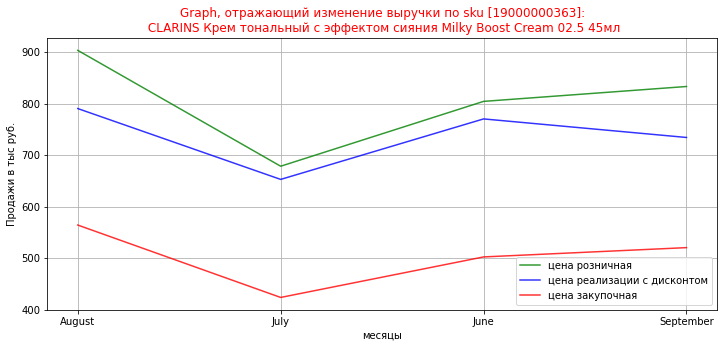

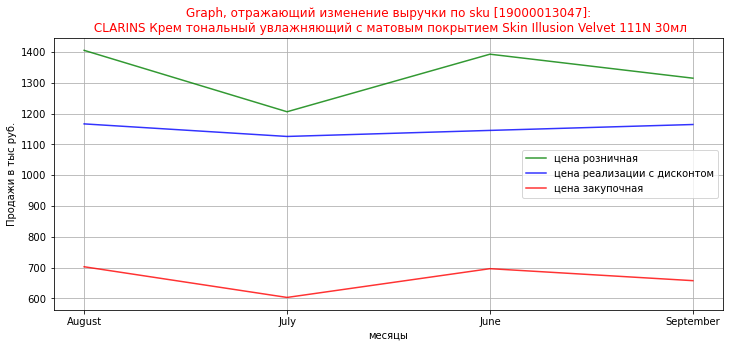

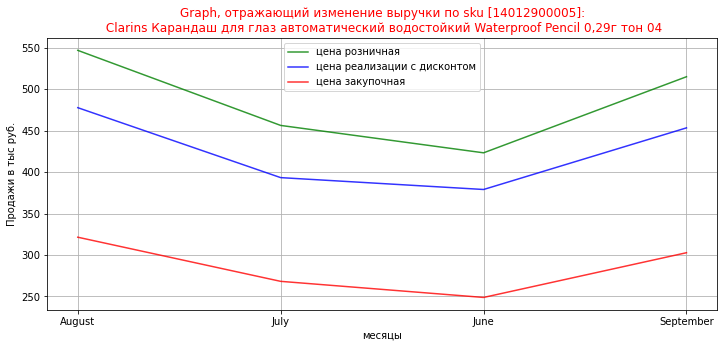

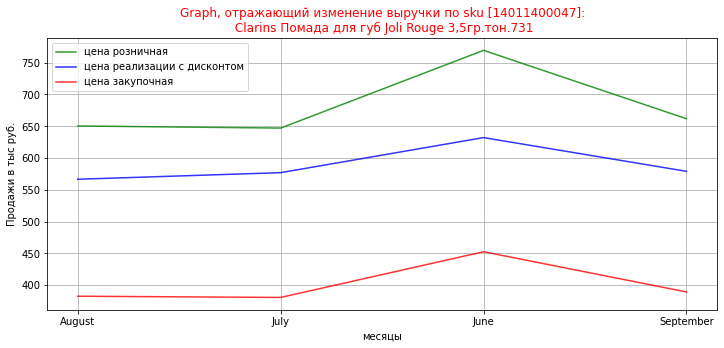

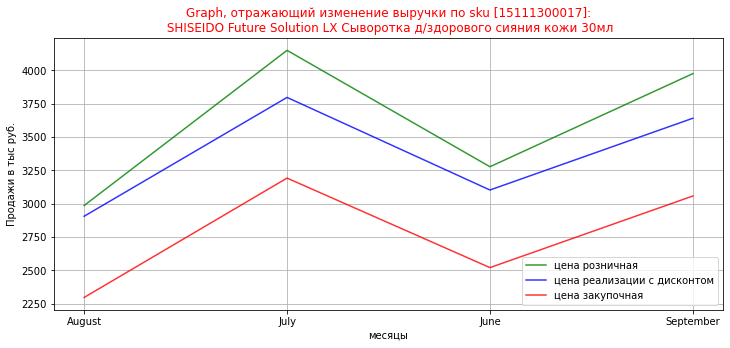

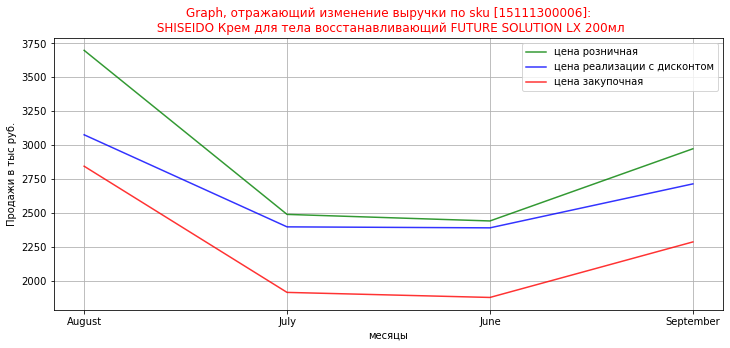

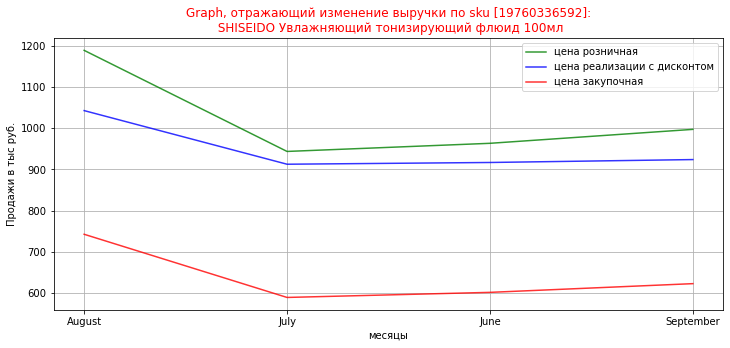

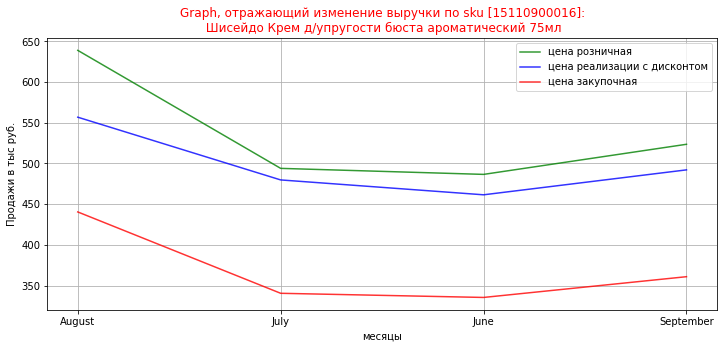

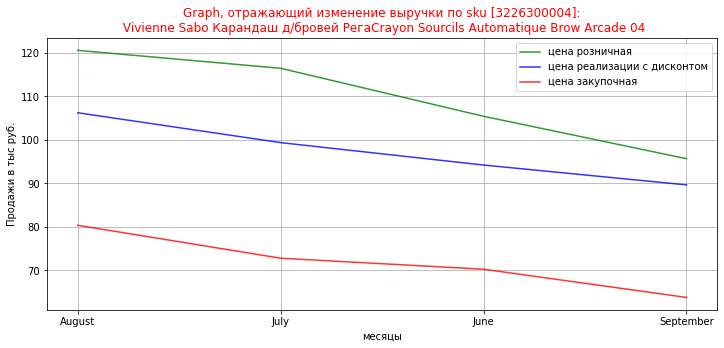

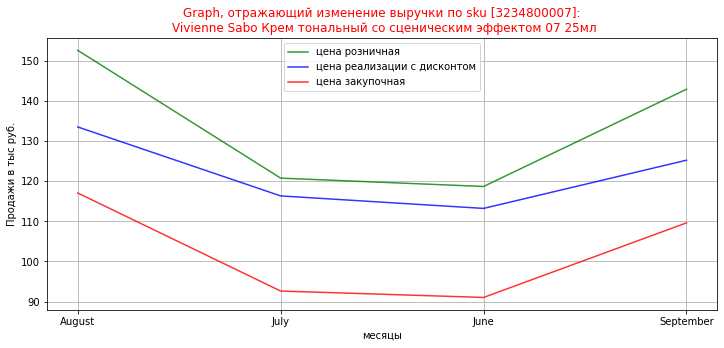

In [856]:
# построим график отражающий изменение выручки (синяя линия) и условные объемы продаж в ценах закупочных и розничных
# по каждому продукту
for p in list(df_monthly_sell.code.unique()):
    df_p = df_monthly_sell[df_monthly_sell['code']==p]
    get_graph_sell(df_p)
    

- колебания цены розничной повторяют колебания цены закупочной, то есть наценка в течение периода остается практически постоянной 
- цена реализации с дисконтом меняется в течение рассматриваемых периодов 

- посмотрим как меняется размер скидки и маржи в зависимости от объема продаж (в тыс руб.) по каждому продукту
- также отобразим зависимость количества проданных единиц товара от объема продаж

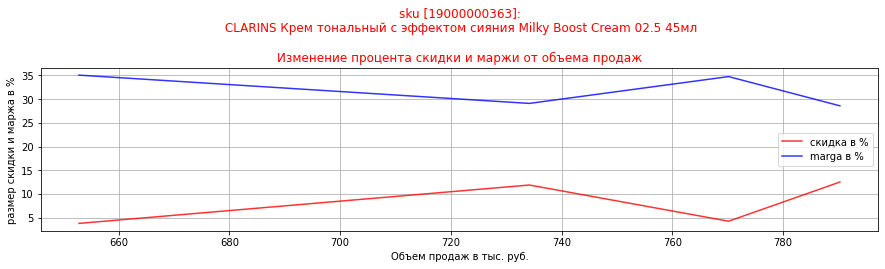

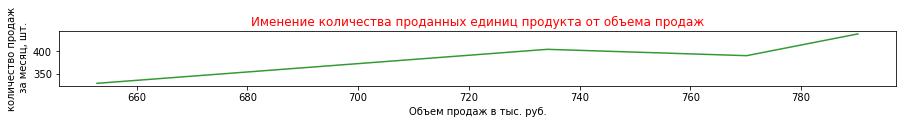

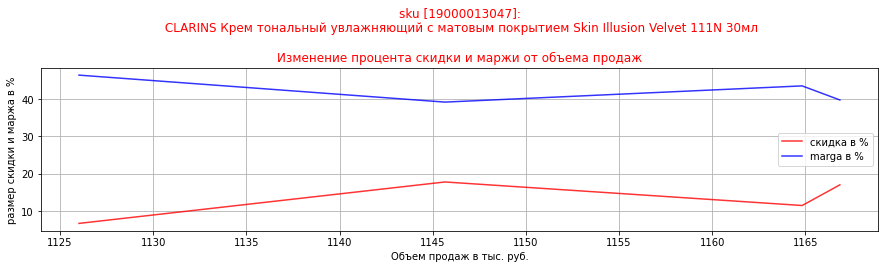

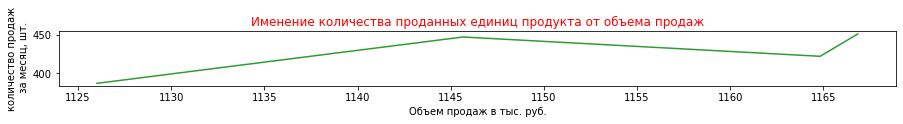

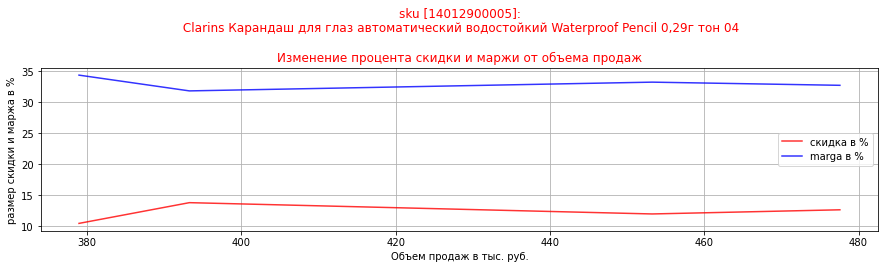

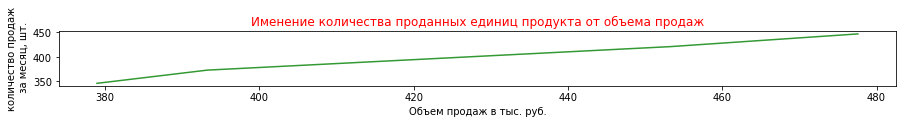

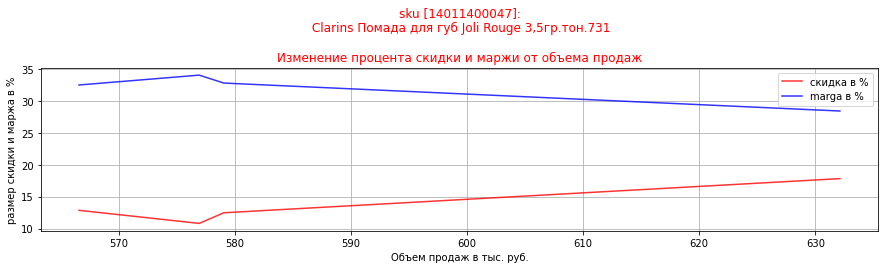

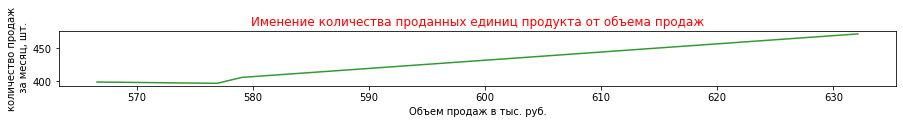

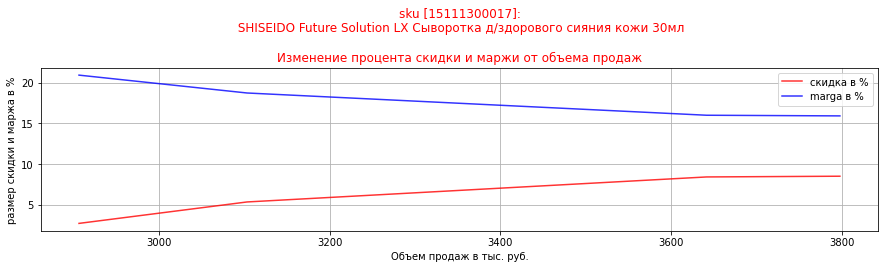

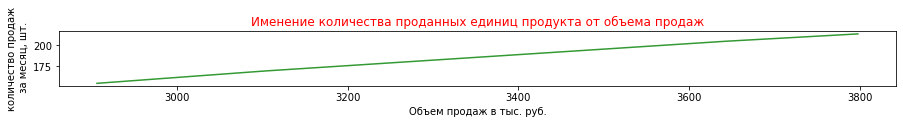

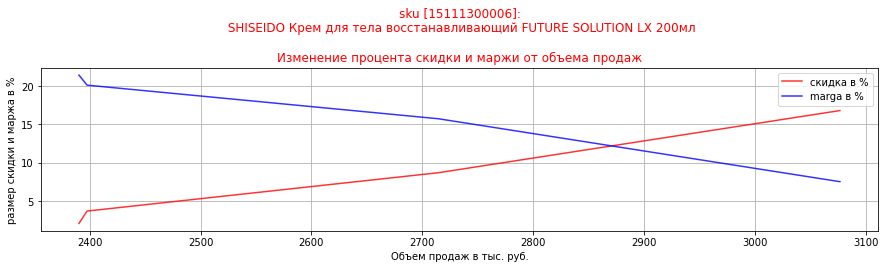

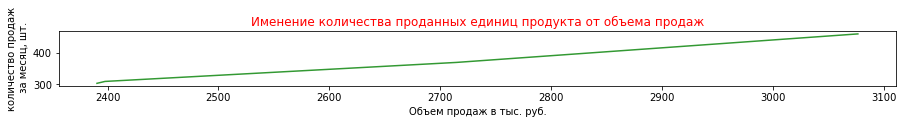

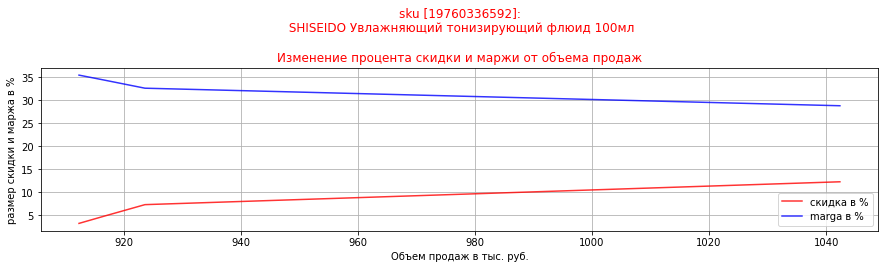

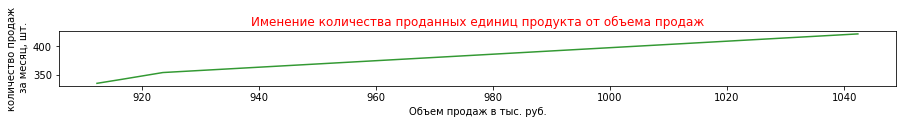

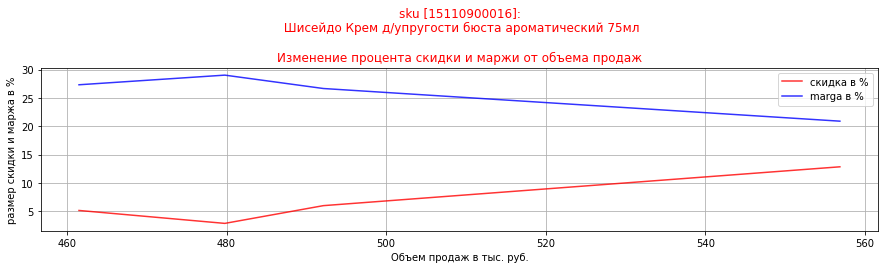

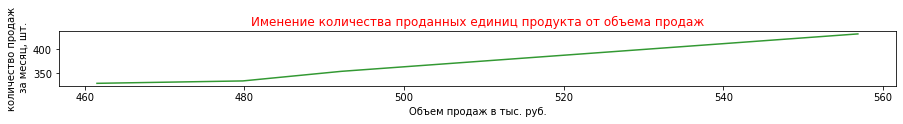

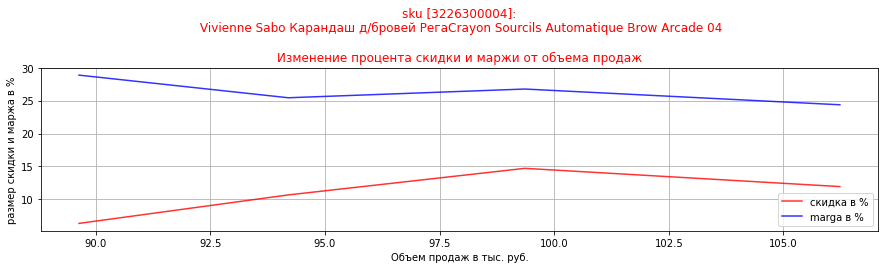

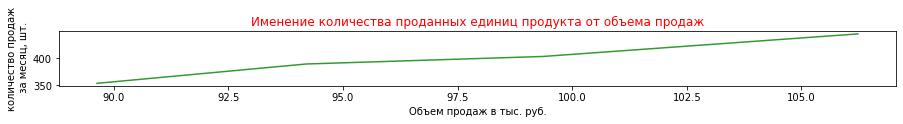

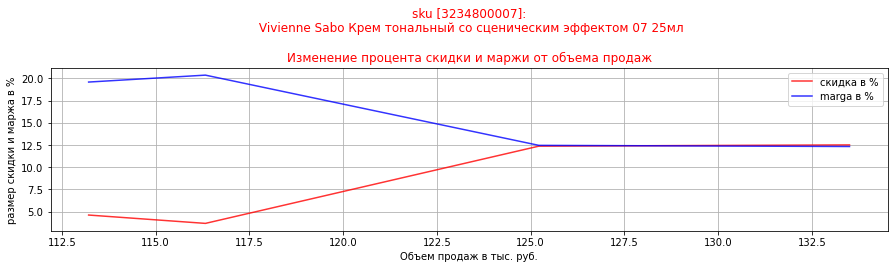

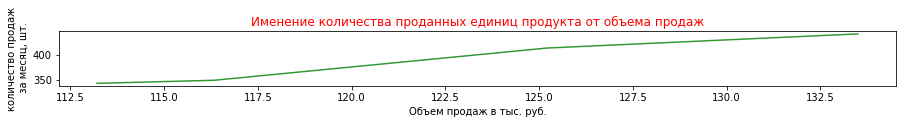

In [908]:
for p in list(df_monthly_sell.code.unique()):
    df_p = df_monthly_sell[df_monthly_sell['code']==p].sort_values(by='sell_discount', ascending=False)
    plt.figure(figsize=(15,3))
    plt.plot(df_p.sell_discount,df_p.discount,color='r',alpha=0.8,label='скидка в %')
    plt.plot(df_p.sell_discount,df_p.margin,color='b',alpha=0.8,label='marga в %')
    plt.title(f"sku [{df_p['code'].unique()[0]}]:\n {df_p['product'].unique()[0]}\n\nИзменение процента скидки и маржи от объема продаж",color='red')
    plt.xlabel('Объем продаж в тыс. руб.')
    plt.ylabel('размер скидки и маржа в %')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15,1))
    plt.plot(df_p.sell_discount,df_p.q_sell,color='g',alpha=0.8,label='кол-во продаж')
    plt.title(f"Именение количества проданных единиц продукта от объема продаж",color='red')
    plt.xlabel('Объем продаж в тыс. руб.')
    plt.ylabel('количество продаж\n за месяц, шт.')
    plt.show()

- изменение маржи и размера скидки зеркальны ( обратно пропорциональны)
- тренд количества продаж от объема выручки повторяет зависимость скидки от выручки

- хотя зависимость объема продаж от скидки не строго линейна, но для расчета апроксимируем тренд и примем его за линейную зависимость
- с учетом этого расчитаем размер скидки при показателе объема продаж, равного двойному увеличению относительно минимального значения месячного объема продаж в выборке по каждому продукту
- также найдем среднее значение маржи для каждого продукта (так как маржа примерно одинакова во всех периодах [месяцах])
-
- после этого останется определить - не будет ли размер скидки превышать размер наценки (маржи) и понять, сможем ли мы предложить такую скидку

- на основе сводного датафрейма [ df_monthly_sell ] вычислим значения мин и макс величин скидки и продаж по каждому продукту
- в этой таблице [ d_rez ] найдем коэффициент k, определяющий угол наклона прямой
- формулой графика будет являться уравнение y=kx+b , где b определим опытным путем и подберем вручную для приближения искомой линии к прямой, введем коэффициент вручную с клавиатуры и добавим в датафрейм для расчета и построения графика

- построим графики для каждого продукта, чтобы убедиться, что мы действительно апроксимировали линейную зависимость скидки от объема продаж
- на графике отметим уровень маржинальной наценки, это тот уровень скидки, который мы не сможем превысить чтобы цена продажи не была ниже цены закупа

In [1080]:
d1 = df_monthly_sell.groupby(['brand','product','code'])['sell_discount'].min().reset_index() 
d1.rename(columns={'sell_discount':'sell_min'},inplace=True)
d1 = d1[['code','sell_min']] 
d2 = df_monthly_sell.groupby(['brand','product','code'])['sell_discount'].max().reset_index()
d2.rename(columns={'sell_discount':'sell_max'},inplace=True)
d2 = d2[['code','sell_max']] 
d3 = df_monthly_sell.groupby(['brand','product','code'])['discount'].max().reset_index()
d3.rename(columns={'discount':'disc_max'},inplace=True)
d3 = d3[['code','disc_max']] 
d4 = df_monthly_sell.groupby(['brand','product','code'])['discount'].min().reset_index()
d4.rename(columns={'discount':'disc_min'},inplace=True)
d4 = d4[['code','disc_min']] 
d5 = df_monthly_sell.groupby(['brand','product','code'])['margin'].mean().reset_index()
d5.rename(columns={'margin':'margin_mean'},inplace=True)
d5 = d5[['code','margin_mean']] 

In [1119]:
# коэффициенты подберем вручную и введем с клавиатуры 
b = []
for i in list(d_rez.code):
    b.append(float(input(i)))
df_b = pd.DataFrame.from_dict(dict(zip(codes,b)),orient='index',columns=['b']).reset_index().rename(columns={'index':'code'})
df_b

1900000036340
19000013047300
140129000052
1401140004750
1511130001715
1511130000650
1976033659260
1511090001645
322630000440
323480000748


code      b
0  19000000363   40.0
1  19000013047  300.0
2  14012900005    2.0
3  14011400047   50.0
4  15111300017   15.0
5  15111300006   50.0
6  19760336592   60.0
7  15110900016   45.0
8   3226300004   40.0
9   3234800007   48.0

In [1122]:
d_rez = pd.merge(d1,d2,on='code').merge(d3,on='code').merge(d4,on='code').merge(d5,on='code').merge(df_b,on='code')
d_rez['k'] = d_rez.apply(lambda x: (x['disc_max']-x['disc_min'])/(x['sell_max']-x['sell_min']),axis=1)
d_rez['sell_calc'] = d_rez.apply(lambda x: x['sell_min']*2,axis=1)  #(x['sell_max']-x['sell_min'])*2
d_rez['disc_calc'] = d_rez.apply(lambda x: x['k']*x['sell_calc']-x['b'],axis=1) 
d_rez # полученная таблица будет выглядеть так

code  sell_min  sell_max  disc_max  disc_min  margin_mean      b  \
0  19000000363   652.829   790.261     12.50      3.77      31.8800   40.0   
1  19000013047  1126.016  1166.850     17.77      6.65      42.2500  300.0   
2  14012900005   378.946   477.581     13.79     10.45      33.0125    2.0   
3  14011400047   566.587   632.114     17.84     10.84      31.9225   50.0   
4  15111300017  2906.491  3797.737      8.50      2.69      17.9100   15.0   
5  15111300006  2390.511  3076.164     16.82      2.08      16.2175   50.0   
6  19760336592   912.384  1042.342     12.29      3.28      32.7625   60.0   
7  15110900016   461.520   556.843     12.85      2.87      25.9750   45.0   
8   3226300004    89.633   106.231     14.69      6.30      26.3775   40.0   
9   3234800007   113.210   133.503     12.51      3.67      16.1875   48.0   

          k  sell_calc   disc_calc  
0  0.063522   1305.658   42.938430  
1  0.272322   2252.032  313.278049  
2  0.033862    757.892   23.663905  
3  0.106826   1133.174   71.052665  
4  0.006519   5812.982   22.894617  
5  0.021498   4781.022   52.781238  
6  0.069330   1824.768   66.511332  
7  0.104697    923.040   51.639208  
8  0.505483    179.266   50.615842  
9  0.435618    226.420   50.632671

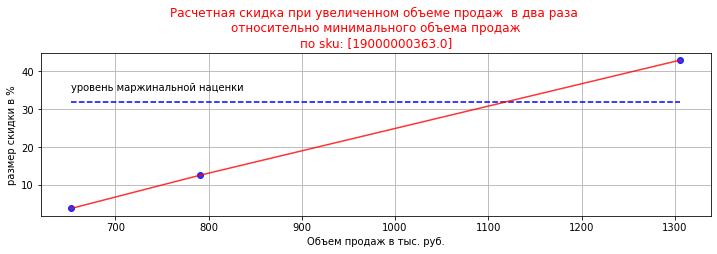

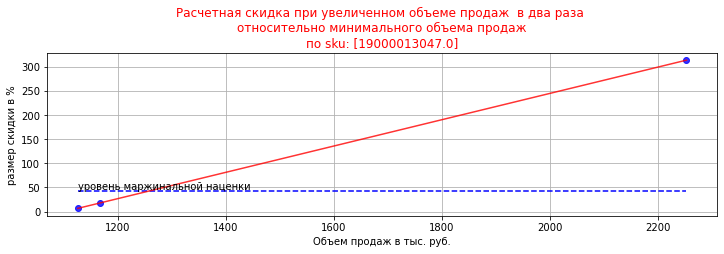

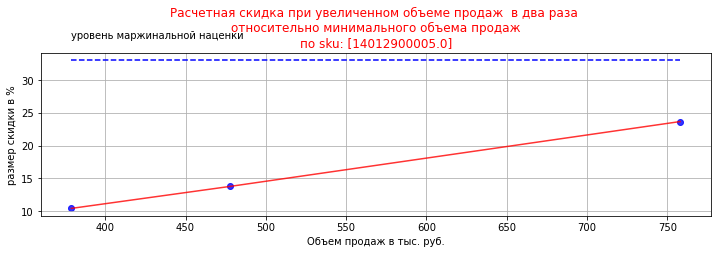

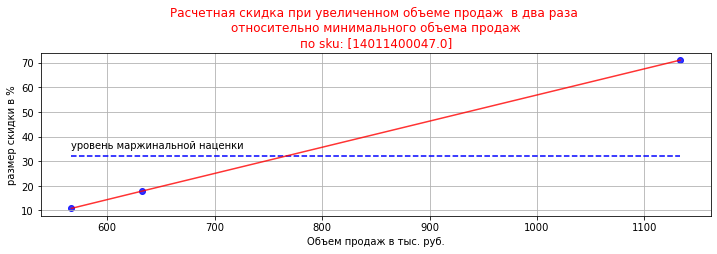

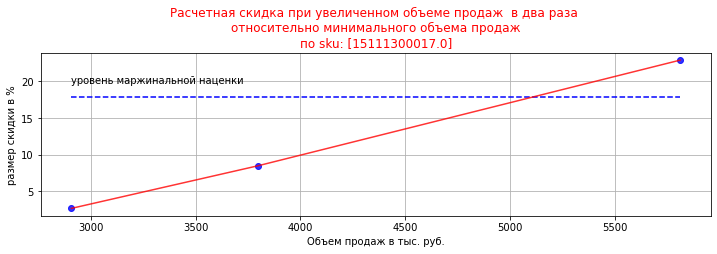

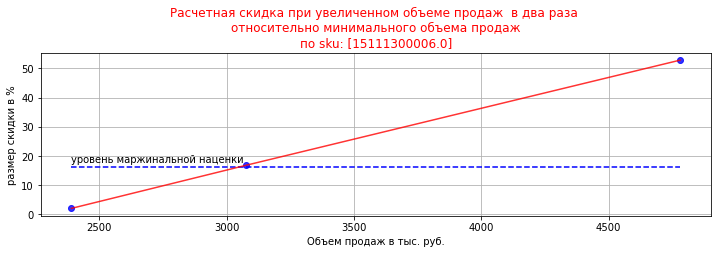

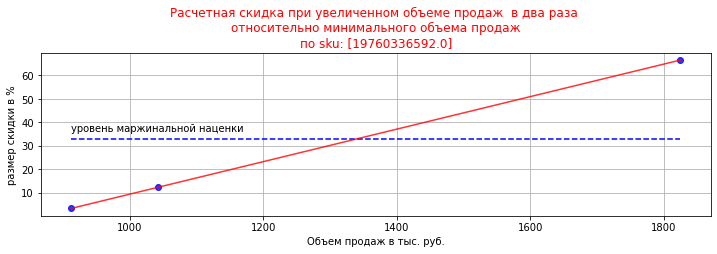

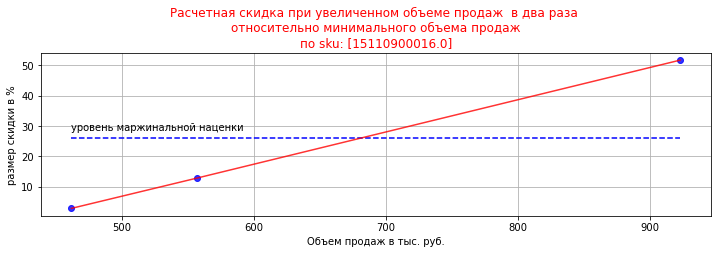

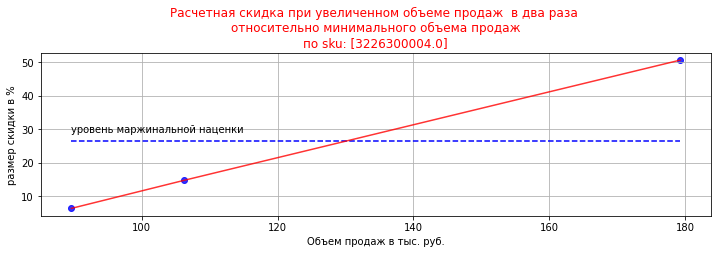

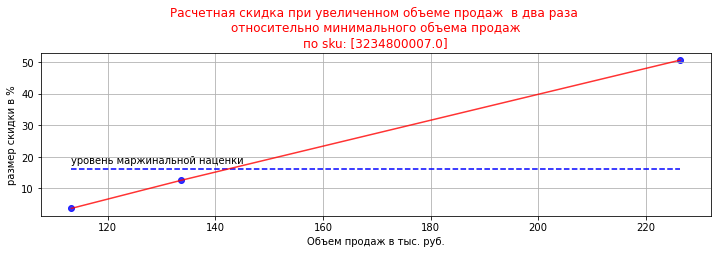

In [1123]:
# построим графики для каждого продукта
codes=list(d_rez.code.unique())
for i in range(len(codes)):
    x1 = d_rez.iloc[i].sell_min
    x2 = d_rez.iloc[i].sell_max
    x3 = d_rez.iloc[i].sell_calc
    y1 = d_rez.iloc[i].disc_min
    y2 = d_rez.iloc[i].disc_max
    y3 = d_rez.iloc[i].disc_calc
    x_=[x1,x2,x3]
    y_=[y1,y2,y3]
    plt.figure(figsize=(12,3))
    plt.plot(x_,y_,color='r',alpha=0.8,label='скидка в %')
    plt.scatter(x_,y_,color='b',alpha=0.8,label='скидка в %')
    plt.title(f"Расчетная скидка при увеличенном объеме продаж  в два раза \nотносительно минимального объема продаж\nпо sku: [{d_rez.iloc[i].code}]",color='red')
    plt.xlabel('Объем продаж в тыс. руб.')
    plt.ylabel('размер скидки в %')
    plt.hlines(d_rez.iloc[i].margin_mean, xmin=x1,xmax=x3,linestyle = '--',color='b')
    plt.text(s='уровень маржинальной наценки',x=x1,y=d_rez.iloc[i].margin_mean*1.1)
    plt.grid()
    plt.show()
    
    

#### следуя гипотезе, что выручка линейно зависит от процента скидки, мы пришли к следующим результатам:
- двойное увеличение объема продаж возможно только для одного продукта (размер скидки не превысит размер наценки и цена продажи не будет ниже закупочной)

In [1136]:
print(f"- Двойное увеличение объема продаж возможно только для одного продукта \n(размер скидки не превысит размер наценки и цена продажи не будет ниже закупочной):  {int(d_rez[d_rez['disc_calc']<d_rez['margin_mean']]['code'])}")
print(f"- Размер скидки для этого продукта составит: {float(round(d_rez[d_rez['disc_calc']<d_rez['margin_mean']]['disc_calc'],1))} %")

Двойное увеличение объема продаж возможно только для одного продукта 
(размер скидки не превысит размер наценки и цена продажи не будет ниже закупочной):  14012900005
Размер скидки для этого продукта составит: 23.7 %


- для остальных продуктов размер скидки будет превышать размер наценки, а это значит цена продажи должна быть ниже закупочной
- в отдельном случае расчетная скидка и вовсе нереальна (составляет 300%) , а это физически невозможно

In [1139]:
print(f"- Для данного продукта расчетная скидка не реальна \n(размер скидки физически невозможен):  {int(d_rez[d_rez['disc_calc']>100]['code'])}")
print(f"- Расчетный размер скидки для этого продукта составит: {float(round(d_rez[d_rez['disc_calc']>100]['disc_calc'],1))} %")

- Для данного продукта расчетная скидка не реальна 
(размер скидки физически невозможен):  19000013047
- Расчетный размер скидки для этого продукта составит: 313.3 %


- у всех остальных продуктов расчетная скидка превысит наценку

- также следуя данной гипотезе по графикам возможно определить максимальный объем месячной выручки, который можно получить по каждому из продуктов 